In [1]:
# Importar as bibliotecas necessárias
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from io import StringIO

# Baixar recursos necessários do nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/joao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/joao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/joao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Carregamento e Combinação de Múltiplos Arquivos CSV

Aqui estamos realizando o carregamento e a combinação de múltiplos arquivos CSV que estão armazenados em um repositório no GitHub. Primeiramente, definimos a URL base e geramos uma lista com os nomes dos arquivos que desejamos carregar. Em seguida, criamos URLs completas para cada arquivo CSV.

Utilizamos uma lista para armazenar os DataFrames individuais que são carregados ao fazer requisições HTTP GET para cada URL. Cada resposta é verificada para garantir que a requisição foi bem-sucedida antes de ler o conteúdo do CSV em um DataFrame. Se a requisição falhar, uma mensagem de erro é impressa.

Após carregar todos os arquivos CSV, combinamos todos os DataFrames em um único DataFrame utilizando a função `concat` do pandas. Finalmente, exibimos as primeiras linhas do DataFrame combinado para verificar se os dados foram carregados corretamente.


In [2]:
base_url = 'https://raw.githubusercontent.com/jvlopess/sentiment-analysis-naive-bayes/main/data/'
file_names = [f'tweets_part_{i}.csv' for i in range(32)]
urls = [base_url + file_name for file_name in file_names]

# Lista para armazenar os DataFrames
dataframes = []
# Baixar e carregar cada arquivo CSV em um DataFrame
for url in urls:
    response = requests.get(url)
    if response.status_code == 200:
        df = pd.read_csv(StringIO(response.text))
        dataframes.append(df)
    else:
        print(f"Failed to fetch {url}")

# Combinar todos os DataFrames em um único DataFrame
df = pd.concat(dataframes, ignore_index=True)

# Exibir as primeiras linhas do DataFrame combinado
df.head()


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### Adição de Títulos de Colunas ao DataFrame

Neste bloco de código, adicionamos títulos de colunas ao DataFrame `df`, uma vez que os dados carregados não possuem cabeçalhos definidos.

Primeiro, definimos os títulos das colunas de acordo com a estrutura dos dados:
- **label:** Indica a classificação do tweet (sentimento).
- **time:** Hora em que o tweet foi postado.
- **date:** Data em que o tweet foi postado.
- **query:** Informação de consulta (geralmente vazia ou irrelevante).
- **username:** Nome de usuário do autor do tweet.
- **tweet:** O texto do tweet.

Após definir os títulos das colunas, aplicamos essas definições ao DataFrame `df` e, em seguida, exibimos as primeiras linhas do DataFrame para verificar se os títulos foram aplicados corretamente.


In [3]:
 # As the data has no column titles, we will add our own
df.columns = ["label", "time", "date", "query", "username", "tweet"]

df.head()

,label,time,date,query,username,tweet
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


### Embaralhamento e Redução do Conjunto de Dados

Neste bloco de código, estamos embaralhando e reduzindo o tamanho do conjunto de dados para facilitar o processamento e a análise.

1. **Embaralhamento do DataFrame:**
   - Utilizamos `df.sample(frac=1)` para embaralhar as linhas do DataFrame `df` aleatoriamente. O parâmetro `frac=1` indica que todas as linhas devem ser incluídas no embaralhamento.

2. **Redução do Tamanho do Conjunto de Dados:**
   - Reduzimos o DataFrame para incluir apenas as primeiras 200.000 linhas utilizando `df = df[:200000]`. Isso é útil para trabalhar com um subconjunto gerenciável dos dados, especialmente em cenários onde o conjunto de dados original é muito grande.

3. **Verificação da Estrutura do Conjunto de Dados:**
   - Imprimimos a forma do DataFrame reduzido com `print("Dataset shape:", df.shape)`, o que nos permite verificar o número de linhas e colunas após o embaralhamento e a redução.

Essas etapas ajudam a garantir que o conjunto de dados seja aleatório e de um tamanho adequado para análises subsequentes.


In [4]:
df = df.sample(frac=1, random_state=42)
df = df[:200000]
print("Dataset shape:", df.shape)

Dataset shape: (200000, 6)


In [5]:
df['label'].value_counts()

label
4    100143
0     99857
Name: count, dtype: int64

### Verificação dos Valores Únicos na Coluna de Rótulos

Neste bloco de código, estamos verificando os valores únicos presentes na coluna `label` do DataFrame `df`.

- **Objetivo:**
  - O objetivo é identificar as diferentes classes ou rótulos presentes no conjunto de dados, que indicam a classificação do sentimento dos tweets.

- **Método:**
  - Utilizamos `df['label'].unique()` para extrair uma lista de valores únicos da coluna `label`.

- **Importância:**
  - Esta etapa é crucial para entender a distribuição dos dados e garantir que os rótulos de classificação sejam consistentes com as expectativas (por exemplo, 0 para sentimentos negativos e 4 para sentimentos positivos).


In [6]:
df['label'].unique()

array([0, 4])

### Currently (0=negative,4=Positive) changing the notation to (0=Negative,1=Positive)

In [7]:
df['label']=df['label'].replace(4,1)
df

,label,time,date,query,username,tweet
541200,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,NO_QUERY,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,NO_QUERY,Young_J,I'm off too bed. I gotta wake up hella early t...
766711,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,NO_QUERY,dougnawoschik,I havent been able to listen to it yet My spe...
285055,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,NO_QUERY,thireven,now remembers why solving a relatively big equ...
705995,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,taracollins086,"Ate too much, feel sick"
...,...,...,...,...,...,...
1421978,1,2058414453,Sat Jun 06 14:53:44 PDT 2009,NO_QUERY,quotemy,watching the big bang theory and talking to my...
43554,0,1676557372,Fri May 01 22:24:38 PDT 2009,NO_QUERY,laurenjessicaH,;( noooo! why? things are so complicated if I...
559176,0,2204916912,Wed Jun 17 03:28:36 PDT 2009,NO_QUERY,monzica,melting next to a heater = static hair!
1287523,1,2002375219,Tue Jun 02 04:01:39 PDT 2009,NO_QUERY,mathaba_forum,@dwaynekerr great one


### Remoção de Colunas Desnecessárias

Neste bloco de código, estamos simplificando o DataFrame `df` removendo colunas que não são relevantes para a análise de sentimentos dos tweets.

1. **Remoção de Colunas `date`, `query` e `username`:**
   - Utilizamos `df.drop(['date', 'query', 'username'], axis=1, inplace=True)` para remover as colunas `date`, `query` e `username`. Estas colunas não são necessárias para a tarefa de classificação de sentimentos e são removidas para simplificar o DataFrame.

2. **Remoção da Coluna `time`:**
   - Removemos a coluna `time` separadamente utilizando `df.drop('time', axis=1, inplace=True)`, pois ela também não é relevante para a análise de sentimentos.

3. **Exibição das Primeiras Linhas do DataFrame Modificado:**
   - Utilizamos `df.head(10)` para exibir as primeiras 10 linhas do DataFrame após a remoção das colunas. Isso nos permite verificar que as colunas foram removidas corretamente e que o DataFrame agora contém apenas as colunas `label` e `tweet`.

A remoção dessas colunas ajuda a focar apenas nos dados necessários para a análise, facilitando o processamento e a modelagem subsequentes.


In [8]:
df.drop(['date','query','username'], axis=1, inplace=True)
df.drop('time', axis=1, inplace=True)
df.head(10)

,label,tweet
541200,0,@Nkluvr4eva My poor little dumpling In Holmde...
750,0,I'm off too bed. I gotta wake up hella early t...
766711,0,I havent been able to listen to it yet My spe...
285055,0,now remembers why solving a relatively big equ...
705995,0,"Ate too much, feel sick"
379611,0,Tried to purchase a parked domain through GoDa...
1189017,1,on lunch....dj should come eat with me
667030,0,Just got back from VA Tech Equine Medical Cent...
93541,0,can't log in to my other twitter account. supe...
1365937,1,@TamaraSchilling Adventure - That's what we al...


### Função para Limpeza dos Tweets

Neste bloco de código, definimos a função `process_tweets` para realizar o pré-processamento dos textos dos tweets. Esta função aplica várias etapas de limpeza e transformação para preparar os dados para a análise de sentimentos.

1. **Conversão para Minúsculas:**
   - `tweet = tweet.lower()`
   - Converte todo o texto do tweet para letras minúsculas, garantindo consistência e evitando duplicidades baseadas em diferenças de capitalização.

2. **Remoção de URLs:**
   - `tweet = re.sub(r'http\S+|www.\S+', '', tweet)`
   - Remove quaisquer URLs presentes no tweet, pois elas geralmente não contribuem para a análise de sentimentos.

3. **Remoção de Menções:**
   - `tweet = re.sub(r'@\w+', '', tweet)`
   - Remove menções a outros usuários do Twitter, que começam com '@', para focar no conteúdo textual principal.

4. **Remoção de Números:**
   - `tweet = re.sub(r'\d+', '', tweet)`
   - Remove todos os números do tweet, pois geralmente não são úteis para a análise de sentimentos.

5. **Remoção de Pontuações:**
   - `tweet = tweet.translate(str.maketrans('', '', string.punctuation))`
   - Remove todos os sinais de pontuação para simplificar o texto.

6. **Tokenização:**
   - `tokens = word_tokenize(tweet)`
   - Divide o texto em tokens individuais (palavras), facilitando o processamento subsequente.

7. **Remoção de Stop Words:**
   - `tokens = [word for word in tokens if word not in stopwords.words('english')]`
   - Remove stop words, que são palavras comuns (como "and", "the", etc.) que não adicionam significado relevante ao texto.

8. **Lematização:**
   - `lemmatizer = WordNetLemmatizer()`
   - `tokens = [lemmatizer.lemmatize(word) for word in tokens]`
   - Reduz as palavras às suas formas base ou raiz (por exemplo, "running" para "run"), ajudando a normalizar o texto.

9. **Recomposição do Texto:**
   - `return ' '.join(tokens)`
   - Reúne os tokens processados em uma string única, representando o texto do tweet limpo e preparado para análise.

Essa função de limpeza garante que os textos dos tweets estejam em um formato consistente e livre de ruídos, facilitando a análise e melhorando o desempenho dos modelos de aprendizado de máquina.


In [9]:
def process_tweets(tweet):
    # Lower case
    tweet = tweet.lower()
    # Remove URLs
    tweet = re.sub(r'http\S+|www.\S+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove números
    tweet = re.sub(r'\d+', '', tweet)
    # Remove pontuações
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Tokenização
    tokens = word_tokenize(tweet)
    # Remover stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    # Lematização
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

### Aplicação da Limpeza dos Tweets e Preparação dos Dados

Neste bloco de código, aplicamos a função de limpeza aos tweets, realizamos a vetorização dos textos e preparamos os dados para treinamento e teste.

1. **Aplicação da Função de Limpeza:**
   - `df['tweet'] = df['tweet'].apply(process_tweets)`
   - Aplica a função `process_tweets` a cada tweet na coluna `tweet` do DataFrame `df`. Isso transforma os tweets brutos em textos limpos e padronizados, prontos para a vetorização.

2. **Vetorização usando CountVectorizer:**
   - `vectorizer = CountVectorizer(max_features=5000)`
   - `X = vectorizer.fit_transform(df['tweet'])`
   - Utiliza `CountVectorizer` para converter os textos dos tweets em uma matriz de contagens de palavras. Limitamos o número de características (palavras) a 5000 para manter a complexidade gerenciável.
   - `X` é a matriz de características resultante da vetorização.

3. **Preparação das Variáveis Dependente e Independente:**
   - `y = df['label']`
   - Define `y` como a variável dependente contendo os rótulos (sentimentos) dos tweets.

4. **Divisão do Conjunto de Dados:**
   - `X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)`
   - Divide os dados em conjuntos de treinamento e teste. Utilizamos 80% dos dados para treinamento (`X_train`, `y_train`) e 20% para teste (`X_test`, `y_test`).
   - O parâmetro `random_state=42` garante que a divisão dos dados seja reprodutível.

Essas etapas preparam os dados textuais para serem utilizados em modelos de aprendizado de máquina, convertendo-os de texto cru para uma representação numérica que pode ser processada por algoritmos.


In [10]:
# Aplicar a limpeza dos tweets
df['tweet'] = df['tweet'].apply(process_tweets)

# Vetorização usando CountVectorizer
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['tweet'])
y = df['label']

# Dividir o conjunto de dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Treinamento do Modelo Naive Bayes

Neste bloco de código, estamos treinando um modelo de Naive Bayes Multinomial com os dados de treinamento.

1. **Criação do Modelo Multinomial Naive Bayes:**
   - `clf = MultinomialNB()`
   - Inicializamos um classificador Multinomial Naive Bayes, que é apropriado para dados de contagem, como os gerados pelo `CountVectorizer`.

2. **Treinamento do Modelo:**
   - `clf.fit(X_train, y_train)`
   - Ajustamos o modelo `clf` aos dados de treinamento. O método `fit` treina o modelo usando as matrizes de características `X_train` e os rótulos `y_train`.

Ao final deste bloco, o modelo Multinomial Naive Bayes foi treinado com os dados de treinamento, estando pronto para fazer previsões e ser avaliado em novos dados.


In [11]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

### Avaliação do Modelo Nos Conjuntos de Treinamento e Teste

Neste bloco de código, estamos avaliando o desempenho do modelo treinado tanto no conjunto de treinamento quanto no conjunto de teste.

1. **Avaliação no Conjunto de Treinamento:**
   - `y_pred_train = clf.predict(X_train)`
     - Utilizamos o modelo `clf` para prever os rótulos do conjunto de treinamento `X_train`.
   - `acuracia_train = accuracy_score(y_train, y_pred_train)`
     - Calculamos a acurácia das previsões no conjunto de treinamento comparando `y_pred_train` com os rótulos reais `y_train` usando a função `accuracy_score`.
   - `print(f'Train Accuracy: {acuracia_train}')`
     - Imprimimos a acurácia do modelo no conjunto de treinamento. Esta métrica nos ajuda a entender o quão bem o modelo aprendeu os dados de treinamento.

2. **Avaliação no Conjunto de Teste:**
   - `y_pred_test = clf.predict(X_test)`
     - Utilizamos o modelo `clf` para prever os rótulos do conjunto de teste `X_test`.
   - `acuracia_test = accuracy_score(y_test, y_pred_test)`
     - Calculamos a acurácia das previsões no conjunto de teste comparando `y_pred_test` com os rótulos reais `y_test` usando a função `accuracy_score`.
   - `print(f'Test Accuracy: {acuracia_test}')`
     - Imprimimos a acurácia do modelo no conjunto de teste. Esta métrica nos dá uma ideia do desempenho do modelo em dados novos e não vistos durante o treinamento.

Avaliar o modelo tanto no conjunto de treinamento quanto no conjunto de teste é crucial para detectar possíveis problemas de overfitting ou underfitting. O overfitting ocorre quando o modelo performa muito bem nos dados de treinamento, mas não generaliza bem para novos dados. O underfitting ocorre quando o modelo não performa bem nem nos dados de treinamento nem nos de teste.

In [12]:
#Avaliação no conjunto de treinamento
y_pred_train = clf.predict(X_train)
acuracia_train = accuracy_score(y_train, y_pred_train)
print(f'Train Accuracy: {acuracia_train}')

#Avaliação no conjunto de testes
y_pred_test = clf.predict(X_test)
acuracia_test = accuracy_score(y_test, y_pred_test)
print(f'Test Accuracy: {acuracia_test}')

Train Accuracy: 0.7695375
Test Accuracy: 0.761125


### Relatório de Classificação

Neste bloco de código, estamos gerando um relatório de classificação detalhado para avaliar o desempenho do modelo no conjunto de teste.


In [13]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.76      0.76     20088
           1       0.76      0.77      0.76     19912

    accuracy                           0.76     40000
   macro avg       0.76      0.76      0.76     40000
weighted avg       0.76      0.76      0.76     40000



### Matriz de Confusão

Neste bloco de código, estamos calculando e verificando o tipo da matriz de confusão, que é uma ferramenta essencial para avaliar a performance do modelo de classificação.


In [14]:
cf_matrix = confusion_matrix(y_test, y_pred_test)
print(type(cf_matrix))

<class 'numpy.ndarray'>


### Visualização da Matriz de Confusão

Neste bloco de código, estamos visualizando a matriz de confusão para a classificação dos tweets, utilizando a biblioteca `matplotlib` e a classe `ConfusionMatrixDisplay` do `sklearn.metrics`.

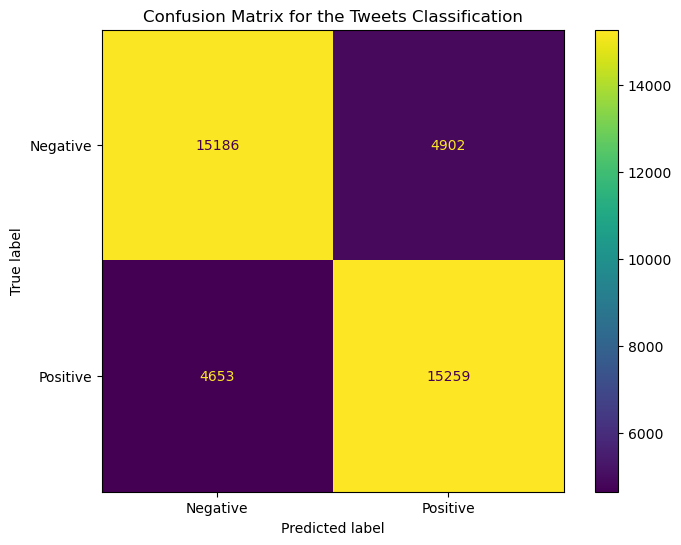

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
 
# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
 
# initialize using the raw 2D confusion matrix 
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(cf_matrix, display_labels= ['Negative', 'Positive'])
 
# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Tweets Classification')
 
# show the plot. 
# Pass the parameter ax to show customizations (ex. title) 
display.plot(ax=ax);